![OCR logo](https://consent.trustarc.com/get?name=oc_logo.png)
# Projet 6 : Modélisation du score de crédit - Notebook 2/2 : Modélisation des données
**Hugo EVRARD**

Notes :  
- *Code initial dans Spyder, puis import et mise en page dans Jupyter Notebook*   
- *Commentaires et critiques dans le document de présentation*

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Chargement des données</h2>
</div>

### 1.1. Import des libraries

In [1]:
# Load packages
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Package pour augmenter la data
from imblearn.over_sampling import SMOTE

# Packages hyperopt pour la séléction d'hyperparamètres
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# Metrics de ML
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from lime.lime_tabular import LimeTabularExplainer

# Packages de cross_validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

# Models
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### 1.2. Création de l'environnement de travail

In [2]:
# Répertoire de travail
PATH_DATA = r"C:\Users\Valentin\Desktop\CreditScore\Data"
PATH_MODEL = r"C:\Users\Valentin\Desktop\CreditScore\saved_model"

### 1.3. Chargement des données

In [3]:
# Lecture des données
df = pd.read_csv(
    os.path.join(PATH_DATA, "app_encoded.csv"),
    sep = ";",
    encoding='utf8'
)
# Set SK_ID_CURR as index
df.set_index('SK_ID_CURR' ,inplace=True)

In [4]:
# Visualisation
df.head(5)

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,...,1,0,0,0,0,0,0,0,1,0
100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,...,1,0,0,1,0,0,0,0,0,0
100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,...,0,0,0,0,0,0,0,0,0,0
100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,...,0,0,0,0,0,0,0,0,0,0
100007,0.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,...,0,0,0,0,0,0,0,0,0,0


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Préparation des données</h2>
</div>

### 2.1. Transformation des données

In [5]:
# Divise df en jeu test et entrainement
train_set = df.loc[~df['Test'], :]
test_set = df.loc[df['Test'], :]

# S'assurer que toutes les variables sont au format float64
train_set = train_set.astype(np.float64)
train_set.drop(columns=["Test"], inplace=True)
test_set = test_set.astype(np.float64)
test_set.drop(columns=["Test"], inplace=True)

# Target labels
y_train = train_set['TARGET']
y_test = test_set["TARGET"]

# Remove test/train indicator column and target column
x_train = train_set.drop(columns=['TARGET'])
x_test = test_set.drop(columns=['TARGET'])

# On split le jeu d'entrainement en entrainement et test
train_set, valid_set = train_test_split(train_set, test_size=0.2, random_state=42)

Pipeline d'imputation des valeurs manquantes et standardisation

Afin de trouver la forme d'imputation des valeurs manqunates la plus perfomante, nous allons définir un simple modèle de régréssion logistique et évaluer les scaler suivant :
* Moyenne
* Médiane
* Valeur la plus fréquente
* Constante

In [6]:
# -- Pipeline de standardisation et d'imputation des valeurs manquantes
# Setup
imputer_score = pd.DataFrame()
imputer = []
accuracy = []
f1 = []

# Define models
Lr = LogisticRegression(
        random_state = 42,
        solver = "saga",
        l1_ratio = 0.5,
        penalty = 'elasticnet',
        n_jobs = -1 # Permet d'effectuer les calculs sur tous les coeurs du processeur
    )
# For lopp
for value in ["mean", "median", "most_frequent", "constant"]:
    # -- Ajout dans la liste
    imputer.append(value)
    # -- Definition du pipeline
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy = value)),
        ('scaler', RobustScaler()),
        ('Logistic', Lr),
    ])
    # -- Fit
    pipe.fit(x_train, y_train)
    # -- Predict
    pred = pipe.predict(valid_set.drop(columns="TARGET"))
    # -- Score
    # Accuracy
    accuracy.append(
        balanced_accuracy_score(valid_set["TARGET"], pred)
        )
    # F1
    f1.append(
        f1_score(valid_set["TARGET"], pred)
        )

# Sauvegarde des résultats
imputer_score["Méthode"] = imputer
imputer_score["Balanced accuracy"] = accuracy
imputer_score["F1"] = f1

In [7]:
# Visualisation des résultats
imputer_score

,Méthode,Balanced accuracy,F1
0,mean,0.500000,0.000000
1,median,0.504431,0.019031
2,most_frequent,0.504399,0.018635
3,constant,0.500918,0.004380


Avec ces résultats, nous pouvons voir que choisir une imputation des valeurs manquantes par la médiane est la meilleure stratégie à avoir. Elle permet de maximiser les deux métriques étudiées.

### 2.2. Features selection

Notre dataset présente de très nombreuses variables et cela amène à un risque d'overfitting et donc de mauvaise construction de notre modèle.
Nous allons donc utiliser le modèle ExtraTreesClassifier pour déterminer les variables clées de notre dataset pour prédire la variable TARGET.

In [8]:
# Feature selection with Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier

# Definition du pipeline
pipe_features = Pipeline([
        ('imputer', SimpleImputer(strategy = 'median')),
        ('scaler', RobustScaler())
    ])
# Definition du modèle
model = ExtraTreesClassifier(
    n_estimators=250, criterion='entropy',
    class_weight={0:0.919, 1:0.081},
    random_state=42, n_jobs=-1
    )
# Fit
model.fit(
    X = pipe_features.fit_transform(x_train),
    y = y_train
)

ExtraTreesClassifier(class_weight={0: 0.919, 1: 0.081}, criterion='entropy',
                     n_estimators=250, n_jobs=-1, random_state=42)

In [9]:
# Stockage des résultats dans une série
feature_names = list(x_train)

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0) # Pour calculer l'écart type

feature_importances = pd.Series(importances, index=feature_names)

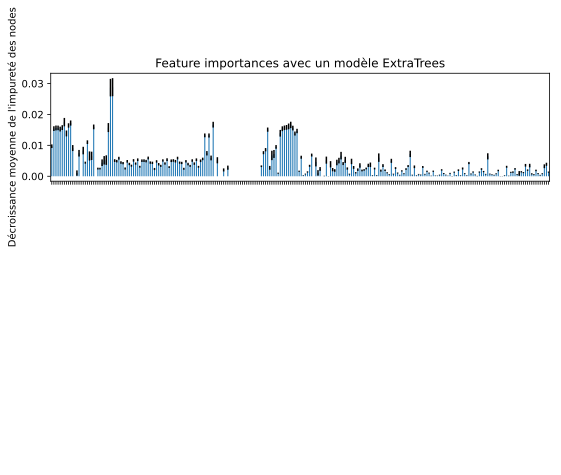

In [10]:
# Visualisation des résultats
fig, ax = plt.subplots(figsize=(8,6))
feature_importances.plot.bar(yerr = std, ax=ax)
ax.set_title("Feature importances avec un modèle ExtraTrees")
ax.set_ylabel("Décroissance moyenne de l'impureté des nodes")
plt.xticks(color='w')
fig.tight_layout()

In [11]:
# Regarder les variables importantes au seil de 0.01
feature_importances[feature_importances > 0.01]

AMT_INCOME_TOTAL                  0.015410
AMT_CREDIT                        0.015625
AMT_ANNUITY                       0.015652
AMT_GOODS_PRICE                   0.015262
REGION_POPULATION_RELATIVE        0.015741
DAYS_BIRTH                        0.017511
DAYS_EMPLOYED                     0.013856
DAYS_REGISTRATION                 0.016434
DAYS_ID_PUBLISH                   0.017225
CNT_FAM_MEMBERS                   0.011026
HOUR_APPR_PROCESS_START           0.015968
EXT_SOURCE_1                      0.015750
EXT_SOURCE_2                      0.028672
EXT_SOURCE_3                      0.028816
OBS_30_CNT_SOCIAL_CIRCLE          0.013226
OBS_60_CNT_SOCIAL_CIRCLE          0.013194
DAYS_LAST_PHONE_CHANGE            0.016696
AMT_REQ_CREDIT_BUREAU_YEAR        0.015084
PROPORTION_LIFE_EMPLOYED          0.013915
INCOME_TO_CREDIT_RATIO            0.015375
INCOME_TO_ANNUITY_RATIO           0.015693
INCOME_TO_ANNUITY_RATIO_BY_AGE    0.015825
CREDIT_TO_ANNUITY_RATIO           0.016137
CREDIT_TO_A

In [12]:
# Combien de variables ont une importance supérieure à 0.01 ?
feature_importances[feature_importances > 0.01].shape

(27,)

On voit que seulement 27 variables ont une importance supérieure à 0.01. Nous pouvons donc supprimer les autres variables, ce qui représente une réduction du nombre de variables de 211.

In [13]:
# Suppression des autres variables
var_list = feature_importances[feature_importances > 0.01].index.tolist()
var_list.append("TARGET")

train_set = train_set[var_list]

train_set, valid_set = train_test_split(train_set, test_size=0.2, random_state=42)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3. Modélisation des données</h2>
</div>

### 3.1. Séléction du meilleur modèle en fonction de la métrique AUC

In [14]:
# Définition des pipelines
data_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])

# Définition des différents modèles à tester
r_s = 42
cores = -1

liste_classifiers = {
    'Dummy Classifier': DummyClassifier(random_state=r_s),
    'Logistic Regression': LogisticRegression(random_state=r_s, n_jobs=cores),
    'Random Forest': RandomForestClassifier(random_state=r_s, n_estimators=100, n_jobs=cores),
    'AdaBoost': AdaBoostClassifier(random_state=r_s),
    'Xgboost': XGBClassifier(n_estimators=100, learning_rate = 0.005, n_jobs = cores),
    'LGBM': LGBMClassifier()
    }

In [15]:
# Definition des fonctions
def define_pipeline(preprocessor, classifier) :
    
    pipe = Pipeline([("preprocess", preprocessor),
                     ("regressor", classifier),
                    ])
    return pipe

def plot_roc_curve(classifiers, var_pipeline, X, y, n_splits=5, fit=True):
    kf = KFold(n_splits=n_splits)    
    for name_clf, clf in classifiers.items():
        print(name_clf)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for i, (train, test) in enumerate(kf.split(X, y)):

            full_pipeline = define_pipeline(var_pipeline, clf)
            
            if fit :
                full_pipeline.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = full_pipeline.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            auc_ = auc(fpr, tpr)

            aucs.append(auc_)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positif')
    plt.ylabel('Taux de vrai positif')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

Dummy Classifier
Logistic Regression
Random Forest
AdaBoost
Xgboost
[16:45:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[1

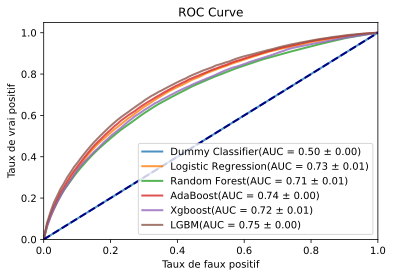

In [16]:
plot_roc_curve(liste_classifiers, data_pipeline, train_set.drop(columns="TARGET"), train_set["TARGET"])

On voit donc que, d'après le score AUC, le modèle LightGBM performe le mieux.
Nous allons donc utiliser ce modèle pour la suite du notebook en poussant l'optimisation du modèle avec une recherche des meilleurs hyperparamètres.

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Optimisation des hyperparamètres</h2>
</div>

Définition de la fonction d'optimisation des hyperparamètres

In [17]:
# Définition de la fonction
def modelOptimizer(predictor, pipeline, features, eval_metric, cv=StratifiedKFold(n_splits=5)):
    # Extract the ids
    train_ids = features.index

    # Extract the targets for training
    targets = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns=['TARGET'])
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Apply the pipeline
    features = pipeline.fit_transform(features)
    targets = np.array(targets)    
    
    # Increase the data to get a bigger proportion of positif targets
    sm = SMOTE(random_state=42, sampling_strategy=0.2) # the ratio is chosen
    # to correspond to the pareto law with the 80%/20% ratio
    features_res, targets_res = sm.fit_resample(features, targets.ravel())  

    def optim_score(params,
                    model=predictor,
                    x_train=features_res,
                    y_train=targets_res,
                    cv=cv,
                    eval_metric=eval_metric):

        # the function gets a set of variable parameters in "param"
        params_model = {'n_estimators': int(params['n_estimators']), 
                        'max_depth': int(params['max_depth']), 
                        'learning_rate': params['learning_rate'],
                        'subsample': params['subsample'],
                        'colsample_bytree': params['colsample_bytree'],
                        'num_leaves': int(params['num_leaves']),
                        'reg_alpha': params['reg_alpha'],
                        'reg_lambda': params['reg_lambda'],
        }

        # asssigne les paramètres du modèle
        model.set_params(**params_model)
        
        # Seuil de solvabilité
        threshold = params['solvability_threshold']

        # Cross-validation à 5 passes : retourne le score de probabilité
        y_proba = cross_val_predict(model,
                                    x_train,
                                    y_train,
                                    method='predict_proba',
                                    cv=cv)[:, 1]
       
        # Si proba > seuil alors la prédiction est positive : 1
        y_pred = (y_proba > threshold)
        y_pred = np.array(y_pred > 0) * 1
        
        # Calcul du score suivant la métrique utilisé
        score = eval_metric(y_train, y_pred)

        return 1 - score # Retourne le score

 
    # possible values of parameters
    space={'n_estimators': hp.quniform('n_estimators', 200, 2000, 200),
           'max_depth' : hp.quniform('max_depth', 2, 30, 2),
           'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
           'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
           'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
           'num_leaves': hp.quniform('num_leaves', 4, 100, 4),
           'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
           'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1),
           'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
    }


    best=fmin(fn=optim_score, # function to optimize
              space=space, 
              algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
              max_evals=10, # maximum number of iterations
    )

    # computing the score on the test set
    predictor.set_params(
                   n_estimators=int(best['n_estimators']),
                   max_depth=int(best['max_depth']),
                   learning_rate=best['learning_rate'],
                   subsample=best['subsample'],           
                   colsample_bytree=best['colsample_by_tree'],
                   num_leaves=int(best['num_leaves']),
                   reg_alpha=best['reg_alpha'],
                   reg_lambda=best['reg_lambda'],
                    
    )
    
    # Entrainement du modèle sur tout le jeux de données
    predictor.fit(features, targets)

    # Record the best parameters
    best_parameters = best
    
    # Assemblage de pipeline
    full_pipeline = define_pipeline(pipeline, predictor)

    # Record the feature importances
    feature_importance_values = full_pipeline[-1].feature_importances_
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': feature_importance_values})

    return best_parameters, feature_importances, full_pipeline

### 4.1. Optimisation du modèle en fonction du score F1

La métrique f1_score est la moyenne harmonique de la précision et du rappel.

Alors que la moyenne ordinaire traite de la même manière toutes les valeurs, la moyenne harmonique donne plus de poids aux faibles valeurs. Par conséquent, le classificateur n'obtiendra un bon score F1 que si son rappel et sa précision sont élevés

La précision est l'exactitude des prédictions positives :
- précision = TP / (TP + FP)

TP (abréviation de l'anglais True Positive) est le nombre de vrais positifs et FP est le nombre de faux positifs.
Quant au rappel, c'est le taux d'observations positives ayant été correctement détectées par le classficateur
- rappel = TP / (TP + FN)

FN est le nombre de faux positifs.

In [18]:
# Optimisation en fonction du score F1
best_parameters_f1, feature_importance_f1, model_f1 = modelOptimizer(LGBMClassifier(),
                                                          data_pipeline,
                                                          train_set,
                                                          eval_metric=f1_score)

100%|██████████| 10/10 [09:41<00:00, 58.11s/trial, best loss: 0.3003054707025826]


Voici les meilleurs hyperparamètres pour notre modèle

In [19]:
best_parameters_f1

{'colsample_by_tree': 0.9,
 'learning_rate': 0.05774007831557855,
 'max_depth': 28.0,
 'n_estimators': 1800.0,
 'num_leaves': 44.0,
 'reg_alpha': 0.1,
 'reg_lambda': 0.9,
 'solvability_threshold': 0.375,
 'subsample': 1.0}

In [20]:
# Predict on validation set
y_proba_f1 = model_f1.predict_proba(valid_set.drop(columns=["TARGET"]))[:, 1]
y_pred_f1 = (y_proba_f1 > best_parameters_f1['solvability_threshold'])
y_pred_f1 = np.array(y_pred_f1 > 0) * 1

<AxesSubplot:>

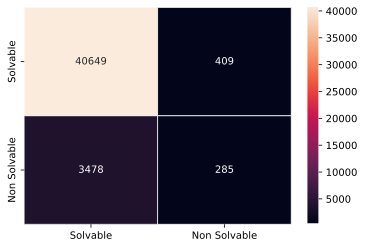

In [21]:
# Matrice de confusion de notre modèle
conf_mx = confusion_matrix(valid_set["TARGET"], y_pred_f1)

mat_conf_df = pd.DataFrame(conf_mx,
                                   columns=["Solvable", "Non Solvable"],
                                   index=["Solvable", "Non Solvable"])
        
sns.heatmap(mat_conf_df, annot=True, linewidths=.7, fmt='g')

In [22]:
# Sauvegarde du modèle
filename = 'banking_model_f1.md'
pickle.dump(model_f1, open(os.path.join(PATH_MODEL, filename), 'wb'))

#### 4.1.1. Prédiction sur les données de test avec notre modèle F1

In [29]:
# Remove unused features
test_set = test_set[var_list]
# Save
test_set.to_csv(
    os.path.join(PATH_DATA, "cleaned_test_set.csv"),
    index = False
)

In [31]:
# Predict
test_set_preds = model_f1.predict(
    data_pipeline.fit_transform(test_set.drop(columns="TARGET"))
)
test_set["TARGET"] = test_set_preds

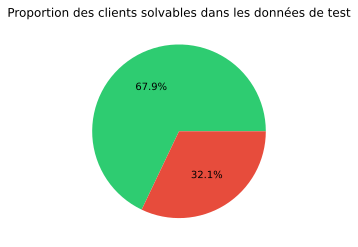

In [32]:
# Visualisation de la proportion de clients solvables
plt.title("Proportion des clients solvables dans les données de test")
plt.pie(test_set["TARGET"].value_counts(),
       colors=["#2ecc71", "#e74c3c"],
       autopct='%1.1f%%',
       radius=1)
plt.show()

### 4.2. Optimisation en fonction de la métrique bancaire

La métrique banking ici crée, consiste à calculer le gain obtenu pour l'ensemble des individus du jeu de données.
Pour cela nous avons fixé un poids arbitraire pour chacune des prédictions relativement à leurs valeurs réelles.

Les valeurs des poids sont les suivantes : 
* fn_value = -10
* tp_value = 0
* tn_value = 1
* fp_value = 0
    
De ce fait, les prêts accordés aux individus qui ne sont finalement pas solvables sont dotés d'une pénalisation négative de -10, alors que les prêts accordés aux individus finalement solvables rapportent 1. Ce rapport 10 est totalement arbitraire et il est tout à fait possible de changer ces valeurs à la convenance de l'optique métier. Il faudra cependant relancer l'optimisation des hyper-paramètres du modèle.

In [33]:
# Définition de la métrique bancaire
def banking_metric(y_true, y_pred, fn_value=-10, fp_value=0, tp_value=0, tn_value=1):
    
    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)

    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]
    
    # Gain total
    J = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    
    # Gain maximum
    max_J = (fp + tn)*tn_value + (fn + tp)*tp_value
    
    # Gain minimum
    min_J = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)
    
    return J_normalized  # Retourne la fonction d'évaluation

In [34]:
# Nouvelles recherches des hyperparamètres
# Optimisation pour la métrique 'roc_auc'
best_parameters_bank, feature_importance_bank, model_bank = modelOptimizer(LGBMClassifier(),
                                                          data_pipeline,
                                                          train_set,
                                                          eval_metric=banking_metric)

100%|██████████| 10/10 [11:49<00:00, 71.00s/trial, best loss: 0.2432480566343599]


In [35]:
# Predict on validation set
y_proba_bank = model_bank.predict_proba(valid_set.drop(columns=["TARGET"]))[:, 1]
y_pred_bank = (y_proba_bank > best_parameters_bank['solvability_threshold'])
y_pred_bank = np.array(y_pred_bank > 0) * 1

<AxesSubplot:>

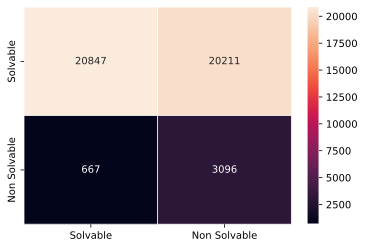

In [36]:
# Matrice de confusion de notre modèle
conf_mx = confusion_matrix(valid_set["TARGET"], y_pred_bank)

mat_conf_df = pd.DataFrame(conf_mx,
                                   columns=["Solvable", "Non Solvable"],
                                   index=["Solvable", "Non Solvable"])
        
sns.heatmap(mat_conf_df, annot=True, linewidths=.7, fmt='g')

In [37]:
def gain_seuil(clf, y_set, x_set):
    
    """
    Evolution du gain en fonction du seuil de solvabilité fixé
    Si score < seuil : client solvable
    Sinon : client non solvable
    """
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 20)
    
    for threshold in threshold_x:
        
        # Score du modèle : 0 à 1
        y_scores = clf.predict_proba(x_set)[:, 1]
        
        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_scores > threshold)
        
        y_pred = np.array(y_pred > 0) * 1
        # Calcul de l'indice bancaire
        cost_function.append(banking_metric(y_set, y_pred))
        
    # Affichage du gain en fonction du seuil de solvabilité    
    plt.plot(threshold_x, cost_function)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice bancaire")
    plt.xticks(np.linspace(0.1, 1, 10))

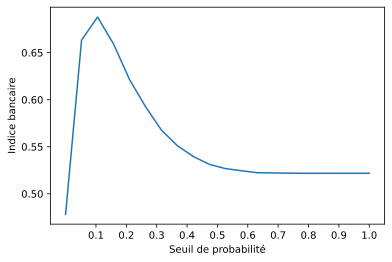

In [38]:
# Affiche le meilleur seuil de probabilité
gain_seuil(model_bank, valid_set["TARGET"], valid_set.drop(columns=["TARGET"]))

On retrouve le fait que le meilleur seuil de solvabilité est de 0.1 comme celui trouvé par l'optimisation via hyperopt.

Le gain obtenu avec un seuil de 0.1 est plus conséquent que pour un seuil par défaut de 0.5 fixé par LGBM

In [39]:
filename = ['banking_model_bank_api.md', 'banking_model_bank_dashboard.md']
# Sauvegarde du modèle
for name in filename:
    pickle.dump(model_bank, open(os.path.join(PATH_MODEL, name), 'wb'))

In [40]:
# Predict
test_set_preds = model_bank.predict(
    data_pipeline.fit_transform(test_set.drop(columns="TARGET"))
)
test_set["TARGET"] = test_set_preds

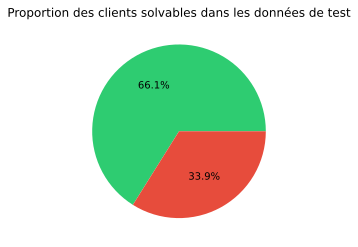

In [41]:
# Visualisation de la proportion de clients solvables
plt.title("Proportion des clients solvables dans les données de test")
plt.pie(test_set["TARGET"].value_counts(),
       colors=["#2ecc71", "#e74c3c"],
       autopct='%1.1f%%',
       radius=1)
plt.show()

Avec la métrique bancaire, 68.4% des clients sont solvables contre seulement 51% pour la métrique F1 

In [42]:
# Sauvegarde des prédictions
test_set.to_csv(
    os.path.join(PATH_DATA,"test_set_with_preds.csv")
    )

### 4.3. Comparaison des deux modèles

In [43]:
def calculate_multi_metrics(clf, x_valid, y_valid, threshold, *metrics):
   
    # liste des scores
    scores = []
    
    # calcule de la probabilité retourné par le modèle
    valid_proba = clf.predict_proba(x_valid)[:, 1]
    # calcule de la prédiction en fonction du threshold
    valid_predictions = (valid_proba > threshold)
    valid_predictions = np.array(valid_predictions > 0) * 1
    
    # Calcule le score pour chaque métrique
    for metric in metrics :
        scores.append(metric(y_valid, valid_predictions))
        
    return scores # retourne la liste des différents scores

In [44]:
# Calcul les scores Accuracy, Recall et Roc_auc pour le modèle F1
scores_f1 = calculate_multi_metrics(model_f1,
                                   valid_set.drop(columns=["TARGET"]),
                                   valid_set["TARGET"],
                                   best_parameters_f1["solvability_threshold"],
                                   *[balanced_accuracy_score, recall_score, roc_auc_score])

In [45]:
# Calcul les scores Accuracy, Recall et Roc_auc pour le modèle Banking
scores_bank = calculate_multi_metrics(model_bank,
                                   valid_set.drop(columns=["TARGET"]),
                                   valid_set["TARGET"],
                                   best_parameters_bank["solvability_threshold"],
                                   *[balanced_accuracy_score, recall_score, roc_auc_score])

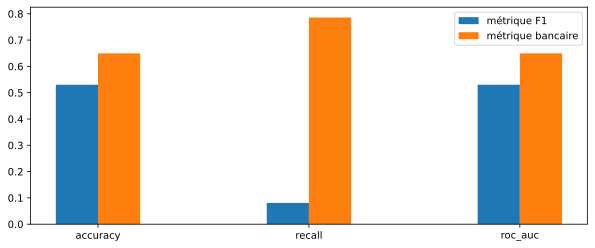

In [46]:
fig, ax = plt.subplots(1, figsize=(10, 4))

x = np.arange(3)  # the label locations
width = 0.2  # the width of the bars

ax.bar(x - width/2, scores_f1, width, label='métrique F1')

ax.bar(x + width/2, scores_bank, width, label='métrique bancaire')

ax.set_xticks(x)
ax.set_xticklabels(['accuracy', 'recall', 'roc_auc'])
ax.legend()
plt.show()

En aillant un score plus élevé pour ces trois métriques, on voit que le modèle optimisé pour la métrique bancaire est plus précis que le modèle optimisé pour le score F1

In [47]:
# Calcule du gain pour la métrique bancaire
J_0 = banking_metric(valid_set["TARGET"], y_pred_bank)
# Calcul du gain pour la métrique métier
J_1 = banking_metric(valid_set["TARGET"], y_pred_f1)
print("Le gain normalisé pour la métrique bancaire est de {:.2f} alors qu'il est de {:.2f} pour la métrique F1"
      .format(J_0, J_1))
print("La création de la métrique bancaire permet un gain de {:.1f}%".format(100*(J_0 - J_1)/J_0))

Le gain normalisé pour la métrique bancaire est de 0.66 alors qu'il est de 0.55 pour la métrique F1
La création de la métrique bancaire permet un gain de 16.0%


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>5. Variables importantes et interprétabilité du modèle</h2>
</div>

### 5.1. Variables importantes

In [48]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending=False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (8, 4))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Importance normalisée'); plt.title('Feature Importances')
    plt.show()
    
    return df

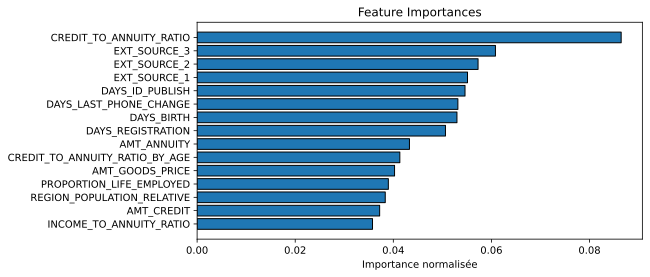

,index,feature,importance,importance_normalized
0,22,CREDIT_TO_ANNUITY_RATIO,1366,0.086456
1,13,EXT_SOURCE_3,961,0.060823
2,12,EXT_SOURCE_2,905,0.057278
3,11,EXT_SOURCE_1,871,0.055127
4,8,DAYS_ID_PUBLISH,863,0.054620
5,16,DAYS_LAST_PHONE_CHANGE,840,0.053165
6,5,DAYS_BIRTH,837,0.052975
7,7,DAYS_REGISTRATION,800,0.050633
8,2,AMT_ANNUITY,684,0.043291
9,23,CREDIT_TO_ANNUITY_RATIO_BY_AGE,653,0.041329


In [49]:
# Affichage de l'importance des features/
plot_feature_importances(feature_importance_bank)

### 5.2. Interprétabilité du modèle

In [50]:
# Transformation du jeu test
test_set = test_set.drop(columns=["TARGET"])

x_test_transformed = pd.DataFrame(model_bank[0].transform(test_set),
                          columns=test_set.columns,
                          index=test_set.index)

nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(x_test_transformed)

# On récupère l'indice des plus proches voisins du premier client de la table
indices = nbrs.kneighbors(x_test_transformed[0:1])[1].flatten()
df.iloc[indices]

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,...,1,0,0,0,0,0,0,0,1,0
102135,1.0,0,360000.0,1236816.0,36162.0,1080000.0,0.011703,-18228,-5388.0,-4617.0,...,1,0,0,0,0,0,0,1,0,0
132271,0.0,0,135000.0,427500.0,39690.0,427500.0,0.010966,-21405,NaN,-1664.0,...,1,0,0,0,0,0,0,1,0,0
127786,0.0,0,135000.0,1036530.0,30438.0,742500.0,0.030755,-19386,-3987.0,-2007.0,...,0,0,0,0,0,0,0,0,0,0
145799,0.0,0,202500.0,284400.0,10345.5,225000.0,0.010006,-19598,NaN,-8862.0,...,1,0,0,0,0,0,0,0,0,1
104556,0.0,0,81000.0,90000.0,10809.0,90000.0,0.018209,-10114,-480.0,-4818.0,...,0,0,0,0,0,0,0,0,0,0
136461,0.0,0,126000.0,455040.0,13171.5,360000.0,0.016612,-15554,-1786.0,-5485.0,...,0,0,0,0,0,0,0,0,0,0
143189,0.0,0,135000.0,916470.0,26928.0,765000.0,0.005144,-17264,-1317.0,-367.0,...,0,0,1,0,0,0,0,0,0,1
141280,0.0,0,90000.0,180000.0,9000.0,180000.0,0.035792,-9761,-537.0,-4146.0,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
# save KNN model
filename = "model_knn.md"
pickle.dump(nbrs, open(os.path.join(PATH_MODEL, filename), 'wb'))

In [51]:
# Importance des features pour un client spécifique
lime1 = LimeTabularExplainer(x_test_transformed,
                             feature_names=x_test.columns,
                             class_names=["Solvable", "Non Solvable"],
                             discretize_continuous=False)
                            

exp = lime1.explain_instance(x_test_transformed.iloc[100],
                             model_bank.predict_proba,
                             num_samples=100)

In [52]:
# Id client
x_test_transformed.index[100]

100763

In [53]:
# Affichage des résultats
exp.show_in_notebook(show_table=False)

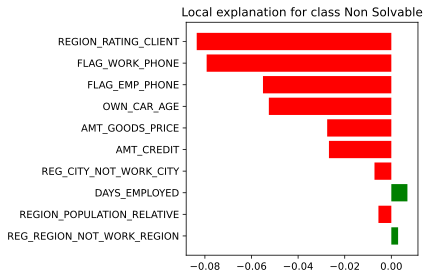

In [54]:
exp.as_pyplot_figure()
plt.tight_layout()

La non solvabilité du client '100763' est supérieur au seuil de solvabilité de 0.1, donc le client est non solvable.
La variable qui joue le plus en sa défaveur est 'REGION_RATING_CLIENT'.
La variable qui joue le plus en sa faveur est 'REG_REGION_NOT_WORK_REGION', il ne vie pas dans la même région qu'il travaille.